---
title: Geographic Analysis
---

# Introduction

bla balal


In [1]:

import findspark
findspark.init()

from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
import numpy as np

np.random.seed(42)

pio.renderers.default = "notebook"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("./data/lightcast_job_postings.csv")

# Show Schema and Sample Data
print("---This is Diagnostic check, No need to print it in the final doc---")

df.printSchema() # comment this line when rendering the submission
df.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 17:14:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


---This is Diagnostic check, No need to print it in the final doc---
root
 |-- ID: string (nullable = true)
 |-- LAST_UPDATED_DATE: string (nullable = true)
 |-- LAST_UPDATED_TIMESTAMP: timestamp (nullable = true)
 |-- DUPLICATES: integer (nullable = true)
 |-- POSTED: string (nullable = true)
 |-- EXPIRED: string (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- SOURCE_TYPES: string (nullable = true)
 |-- SOURCES: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- ACTIVE_URLS: string (nullable = true)
 |-- ACTIVE_SOURCES_INFO: string (nullable = true)
 |-- TITLE_RAW: string (nullable = true)
 |-- BODY: string (nullable = true)
 |-- MODELED_EXPIRED: string (nullable = true)
 |-- MODELED_DURATION: integer (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATIO

25/06/26 17:14:32 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+-----------------+----------------------+----------+--------+---------+--------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+--------+--------------------+-----------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+-------------+------+--------------+-----+--------------------+-----+----------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+------

In [2]:
## Listing Columns So We Can Reference them in Visuals

import pandas as pd
df = pd.read_csv("./data/lightcast_job_postings.csv")
print(df.columns.tolist())

/tmp/ipykernel_1744/3265774581.py:4: DtypeWarning:

Columns (19,30) have mixed types. Specify dtype option on import or set low_memory=False.



['ID', 'LAST_UPDATED_DATE', 'LAST_UPDATED_TIMESTAMP', 'DUPLICATES', 'POSTED', 'EXPIRED', 'DURATION', 'SOURCE_TYPES', 'SOURCES', 'URL', 'ACTIVE_URLS', 'ACTIVE_SOURCES_INFO', 'TITLE_RAW', 'BODY', 'MODELED_EXPIRED', 'MODELED_DURATION', 'COMPANY', 'COMPANY_NAME', 'COMPANY_RAW', 'COMPANY_IS_STAFFING', 'EDUCATION_LEVELS', 'EDUCATION_LEVELS_NAME', 'MIN_EDULEVELS', 'MIN_EDULEVELS_NAME', 'MAX_EDULEVELS', 'MAX_EDULEVELS_NAME', 'EMPLOYMENT_TYPE', 'EMPLOYMENT_TYPE_NAME', 'MIN_YEARS_EXPERIENCE', 'MAX_YEARS_EXPERIENCE', 'IS_INTERNSHIP', 'SALARY', 'REMOTE_TYPE', 'REMOTE_TYPE_NAME', 'ORIGINAL_PAY_PERIOD', 'SALARY_TO', 'SALARY_FROM', 'LOCATION', 'CITY', 'CITY_NAME', 'COUNTY', 'COUNTY_NAME', 'MSA', 'MSA_NAME', 'STATE', 'STATE_NAME', 'COUNTY_OUTGOING', 'COUNTY_NAME_OUTGOING', 'COUNTY_INCOMING', 'COUNTY_NAME_INCOMING', 'MSA_OUTGOING', 'MSA_NAME_OUTGOING', 'MSA_INCOMING', 'MSA_NAME_INCOMING', 'NAICS2', 'NAICS2_NAME', 'NAICS3', 'NAICS3_NAME', 'NAICS4', 'NAICS4_NAME', 'NAICS5', 'NAICS5_NAME', 'NAICS6', 'NAIC

In [3]:
import pandas as pd

df = pd.read_csv("./data/lightcast_job_postings.csv")

columns_to_drop = [
    "ID", "URL", "ACTIVE_URLS", "DUPLICATES", "LAST_UPDATED_TIMESTAMP",
    "NAICS2", "NAICS3", "NAICS4", "NAICS5", "NAICS6",
    "SOC_2", "SOC_3", "SOC_5"
]

df.drop(columns=columns_to_drop, inplace=True)


/tmp/ipykernel_1744/304705447.py:3: DtypeWarning:

Columns (19,30) have mixed types. Specify dtype option on import or set low_memory=False.



In [13]:
print(df.columns.tolist())

['ID', 'LAST_UPDATED_DATE', 'LAST_UPDATED_TIMESTAMP', 'DUPLICATES', 'POSTED', 'EXPIRED', 'DURATION', 'SOURCE_TYPES', 'SOURCES', 'URL', 'ACTIVE_URLS', 'ACTIVE_SOURCES_INFO', 'TITLE_RAW', 'BODY', 'MODELED_EXPIRED', 'MODELED_DURATION', 'COMPANY', 'COMPANY_NAME', 'COMPANY_RAW', 'COMPANY_IS_STAFFING', 'EDUCATION_LEVELS', 'EDUCATION_LEVELS_NAME', 'MIN_EDULEVELS', 'MIN_EDULEVELS_NAME', 'MAX_EDULEVELS', 'MAX_EDULEVELS_NAME', 'EMPLOYMENT_TYPE', 'EMPLOYMENT_TYPE_NAME', 'MIN_YEARS_EXPERIENCE', 'MAX_YEARS_EXPERIENCE', 'IS_INTERNSHIP', 'SALARY', 'REMOTE_TYPE', 'REMOTE_TYPE_NAME', 'ORIGINAL_PAY_PERIOD', 'SALARY_TO', 'SALARY_FROM', 'LOCATION', 'CITY', 'CITY_NAME', 'COUNTY', 'COUNTY_NAME', 'MSA', 'MSA_NAME', 'STATE', 'STATE_NAME', 'COUNTY_OUTGOING', 'COUNTY_NAME_OUTGOING', 'COUNTY_INCOMING', 'COUNTY_NAME_INCOMING', 'MSA_OUTGOING', 'MSA_NAME_OUTGOING', 'MSA_INCOMING', 'MSA_NAME_INCOMING', 'NAICS2', 'NAICS2_NAME', 'NAICS3', 'NAICS3_NAME', 'NAICS4', 'NAICS4_NAME', 'NAICS5', 'NAICS5_NAME', 'NAICS6', 'NAIC

In [7]:
!pip install missingno

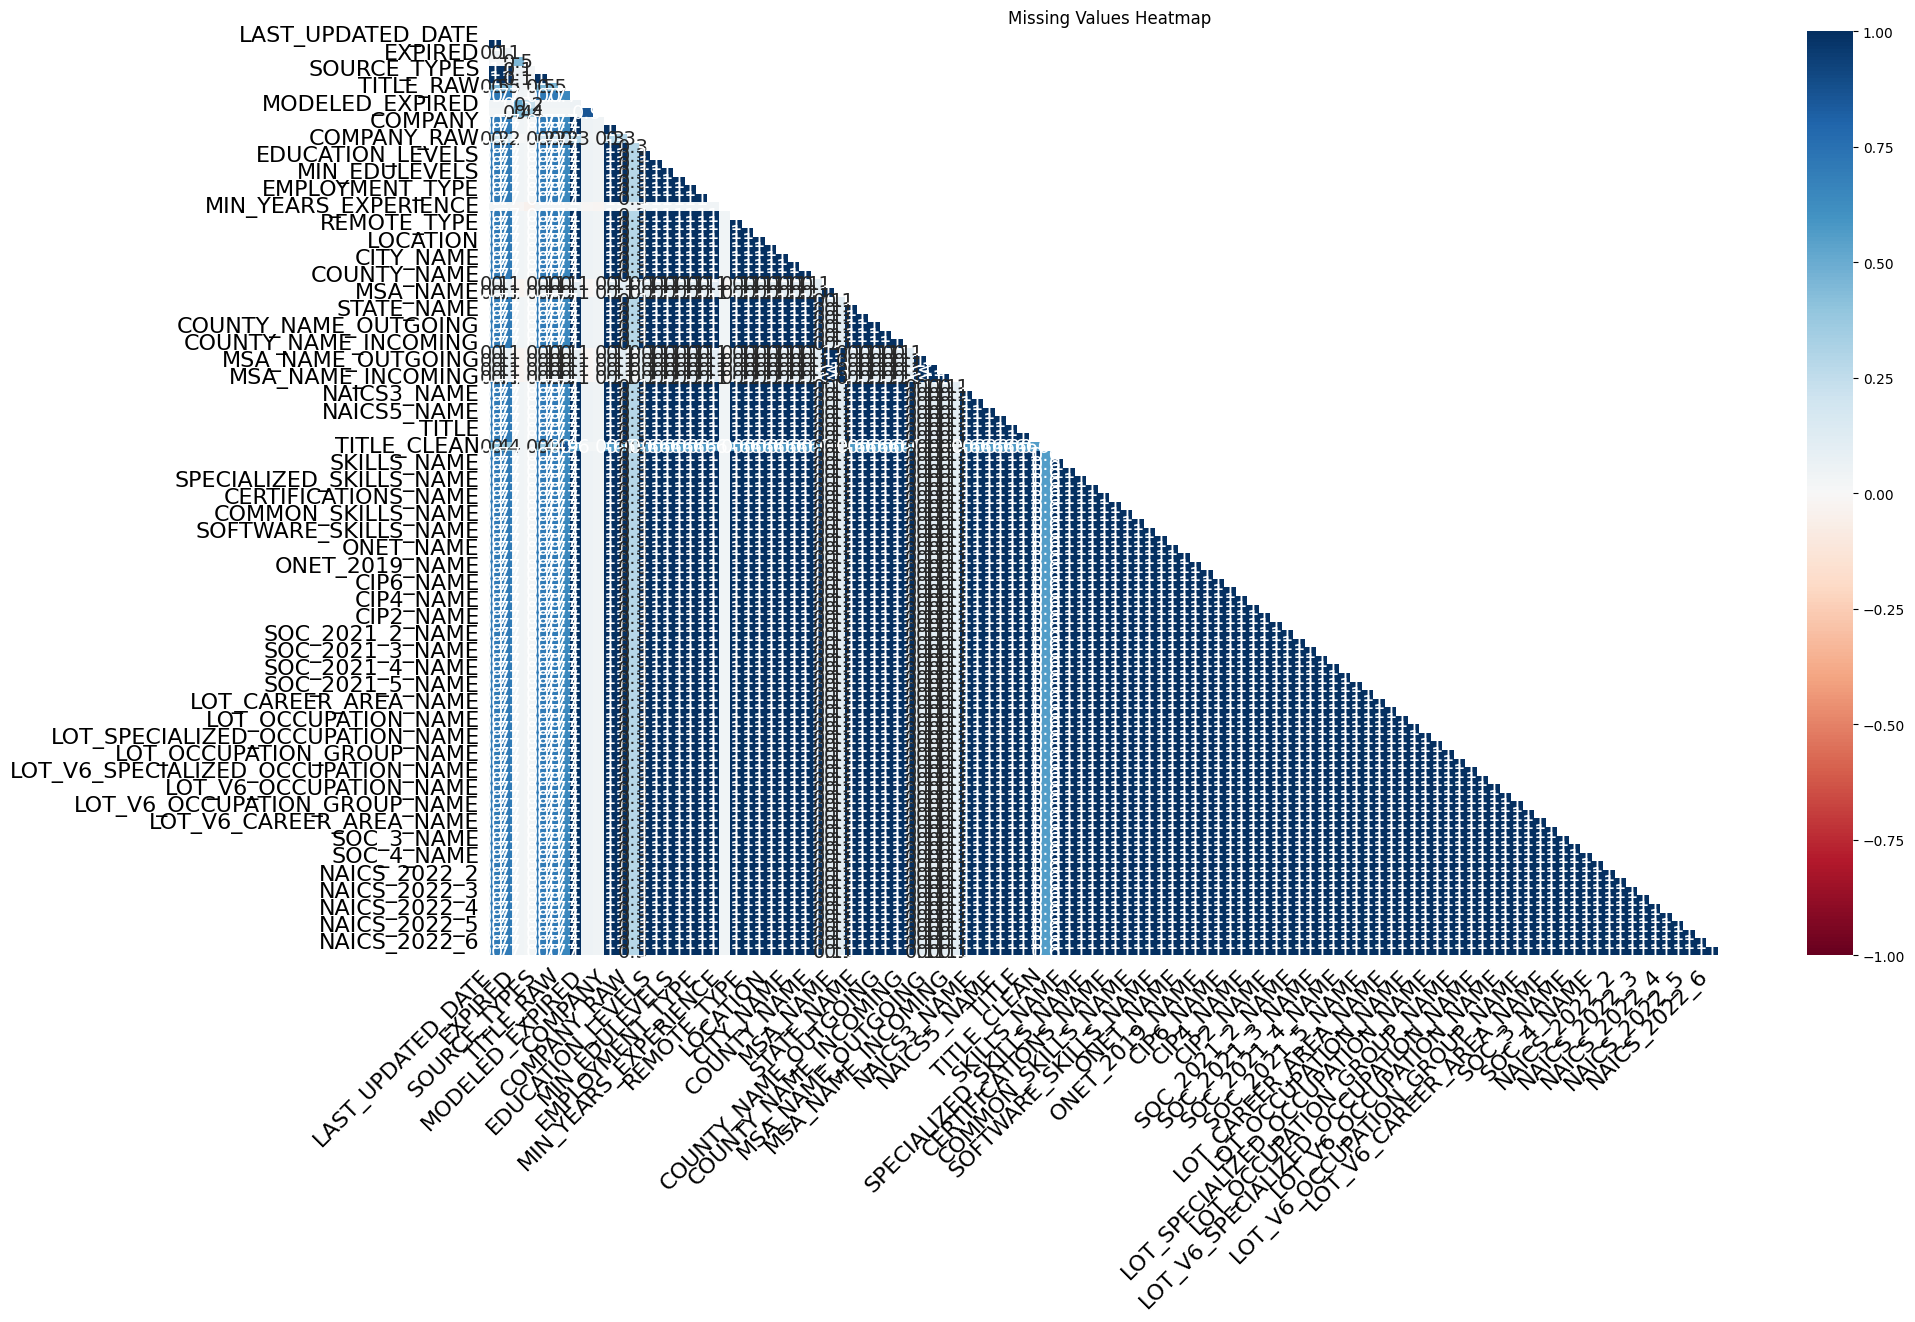

In [8]:
import missingno as msno
import matplotlib.pyplot as plt
# Visualize missing values
msno.heatmap(df)
plt.title("Missing Values Heatmap")
plt.show()

# Drop columns with >50% missing values
df.dropna(thresh=len(df) * 0.5, axis=1, inplace=True)

# Fill only the columns you actually have
if 'Industry' in df.columns:
    df["Industry"].fillna("Unknown", inplace=True)
    df["Salary"].fillna(df["Salary"].median(), inplace=True)

In [9]:
df = df.drop_duplicates(subset=["TITLE", "COMPANY", "LOCATION", "POSTED"], keep="first")

In [7]:
df = df[df['NAICS_2022_2_NAME'] != 'Unclassified Industry']

In [8]:
df['REMOTE_TYPE_NAME'] = df['REMOTE_TYPE_NAME'].replace('[None]', 'Not Remote')




In [14]:
import pandas as pd
import plotly.express as px

# Step 1: Prepare data
data = {
    'Industry': [
        'Wholesale Trade', 'Retail Trade', 'Real Estate and Rental and Leasing',
        'Professional, Scientific, and Technical Services', 'Manufacturing',
        'Information', 'Health Care and Social Assistance',
        'Finance and Insurance', 'Educational Services',
        'Administrative and Support and Waste Management and Remediation Services'
    ],
    'Flexible Remote': [87.8, 94.4, 97.6, 92.2, 89.7, 95.8, 92.1, 94.8, 89.0, 94.8],
    'Onsite': [12.2, 5.6, 2.4, 7.8, 10.3, 4.2, 7.9, 5.2, 11.0, 5.2]
}

df = pd.DataFrame(data)

# Step 2: Sort in ascending order of Flexible Remote
df_sorted = df.sort_values(by='Flexible Remote', ascending=True)
df_sorted['Industry'] = pd.Categorical(df_sorted['Industry'], categories=df_sorted['Industry'], ordered=True)

# Step 3: Melt data for stacked bar format
df_melted = df_sorted.melt(
    id_vars='Industry',
    value_vars=['Flexible Remote', 'Onsite'],
    var_name='Remote Type',
    value_name='Percentage'
)

# Step 4: Plot
fig = px.bar(
    df_melted,
    x='Percentage',
    y='Industry',
    color='Remote Type',
    orientation='h',
    text='Percentage',
    color_discrete_map={
        'Flexible Remote': '#1aab89',
        'Onsite': '#88d4c3'
    },
    title="Remote Job Distribution by Industry (Top 10 Industries)"
)

# Step 5: Layout adjustments
fig.update_layout(
    xaxis_title="Percentage of Jobs",
    yaxis_title="",
    xaxis=dict(tickformat=".0f"),
    legend_title="Remote Type",
    barmode='stack',
    margin=dict(l=10, r=10, t=60, b=40),
    height=500
)

# Step 6: Label formatting
fig.update_traces(texttemplate='%{text:.1f}%', textposition='inside')

# Show plot
fig.show()











In [101]:
import pandas as pd
from IPython.display import display
# 1. Load the dataset and parse dates
df = pd.read_csv("./data/lightcast_job_postings.csv", parse_dates=["POSTED", "EXPIRED"])
# Calculate DURATION in days
df['DURATION'] = (df['EXPIRED'] - df['POSTED']).dt.days
# Extract POSTED month
df['POSTED_MONTH'] = df['POSTED'].dt.to_period("M")

/tmp/ipykernel_2074/784347523.py:4: DtypeWarning:

Columns (19,30) have mixed types. Specify dtype option on import or set low_memory=False.



In [102]:
# Define AI and non-AI impacted NAICS codes
ai_impacted_naics = [31, 32, 33, 42, 44, 45, 51, 52, 54, 55, 56]
non_ai_impacted_naics = [11, 21, 22, 23, 48, 49, 61, 62, 71, 72]

In [103]:
# Create IS_AI_JOB flag
df['IS_AI_JOB'] = df['NAICS_2022_2'].apply(lambda x: 1 if pd.notna(x) and x in ai_impacted_naics else 0)

# Remove rows with missing STATE_NAME or POSTED_MONTH
df = df[df['STATE_NAME'].notna() & df['POSTED_MONTH'].notna()]

# Group by POSTED_MONTH, STATE_NAME, IS_AI_JOB to count jobs
job_counts = (
    df.groupby(['POSTED_MONTH', 'STATE_NAME', 'IS_AI_JOB'])
      .size()
      .reset_index(name='JOB_COUNT')
)


In [104]:
# Pivot to put months as rows, states as columns
pivot_df = job_counts.pivot_table(index=['STATE_NAME', 'IS_AI_JOB'], 
                                   columns='POSTED_MONTH', 
                                   values='JOB_COUNT', 
                                   fill_value=0)

# print(pivot_df.columns)
# print(pivot_df.columns[-1])
# pivot_df.rename(columns={'2024-05': 'May', 
# '2024-06': 'June',
# '2024-07': 'July',
# '2024-08': 'August',
# '2024-09': 'September'
# },inplace=True)
pivot_df['2024-06'].reset_index(drop=True)


0       38.0
1      110.0
2       19.0
3       42.0
4       87.0
       ...  
97      17.0
98      53.0
99     151.0
100      1.0
101     18.0
Name: 2024-06, Length: 102, dtype: float64

In [105]:
# Calculate % growth from first to last month

# pivot_df["PCT_7"]=(pivot_df['2024-07']-pivot_df['2024-06'])*100/pivot_df['2024-06']
# pivot_df["PCT_8"]=(pivot_df['2024-08']-pivot_df['2024-07'])*100/pivot_df['2024-07']
# pivot_df["PCT_9"]=(pivot_df['2024-09']-pivot_df['2024-08'])*100/pivot_df['2024-08']
pivot_df["PCT_CHANGE"]=(pivot_df['2024-09']-pivot_df['2024-05'])*100/pivot_df['2024-05']

pivot_df.head()

POSTED_MONTH          2024-05  2024-06  2024-07  2024-08  2024-09  PCT_CHANGE
STATE_NAME IS_AI_JOB                                                         
Alabama    0             62.0     38.0     18.0     31.0     30.0  -51.612903
           1            100.0    110.0     77.0    132.0     92.0   -8.000000
Alaska     0             13.0     19.0      7.0     18.0     25.0   92.307692
           1             26.0     42.0     30.0     29.0     27.0    3.846154
Arizona    0            102.0     87.0     71.0     72.0     85.0  -16.666667

In [108]:

# Drop rows with undefined % growth (divide by zero)
pivot_df = pivot_df.dropna(subset=['PCT_CHANGE'])

# Reset index for sorting
pivot_df = pivot_df.reset_index()

In [109]:
# Get top 10 states by % growth
top_ai = pivot_df[pivot_df['IS_AI_JOB'] == 1].sort_values('PCT_CHANGE', ascending=False).head(10)
top_non_ai = pivot_df[pivot_df['IS_AI_JOB'] == 0].sort_values('PCT_CHANGE', ascending=False).head(10)

# Combine and label
top_combined = pd.concat([
    top_ai.assign(JOB_TYPE='AI'),
    top_non_ai.assign(JOB_TYPE='Non-AI')
])

# Display 
display(top_combined[['STATE_NAME', 'IS_AI_JOB', 'PCT_CHANGE', 'JOB_TYPE']])


POSTED_MONTH,STATE_NAME,IS_AI_JOB,PCT_CHANGE,JOB_TYPE
101,Wyoming,1,380.000000,AI
97,West Virginia,1,380.000000,AI
81,South Dakota,1,175.000000,AI
21,Hawaii,1,75.000000,AI
67,North Dakota,1,64.285714,AI
61,New Mexico,1,56.000000,AI
73,Oregon,1,54.716981,AI
41,Massachusetts,1,40.074906,AI
95,"Washington, D.C. (District of Columbia)",1,36.363636,AI
53,Nebraska,1,36.065574,AI


In [ ]:
def label_ai_impact(naics):
    try:
        code = int(naics)
        if code in ai_impacted_naics:
            return "AI-Impacted"
        elif code in non_ai_impacted_naics:
            return "Non-AI-Impacted"
        else:
            return "Unclassified"
    except:
        return "Unclassified"

In [ ]:
df['AI_IMPACTED'] = df['NAICS_2022_2'].apply(label_ai_impact)
# Filter only AI and Non-AI impacted
df = df[df["AI_IMPACTED"].isin(["AI-Impacted", "Non-AI-Impacted"])]

# Now split the data
ai_df = df[df["AI_IMPACTED"] == "AI-Impacted"][
    ["STATE_NAME", "NAICS_2022_2", "NAICS_2022_2_NAME", "LOT_SPECIALIZED_OCCUPATION_NAME"]
]

non_ai_df = df[df["AI_IMPACTED"] == "Non-AI-Impacted"][
    ["STATE_NAME", "NAICS_2022_2", "NAICS_2022_2_NAME", "LOT_SPECIALIZED_OCCUPATION_NAME"]
]


In [ ]:
from IPython.display import display

print("AI-Impacted Industries:")
display(ai_df)

print("\nNon-AI-Impacted Industries:")
display(non_ai_df)


AI-Impacted Industries:


,STATE_NAME,NAICS_2022_2,NAICS_2022_2_NAME,LOT_SPECIALIZED_OCCUPATION_NAME
0,Arkansas,44.0,Retail Trade,General ERP Analyst / Consultant
1,Maine,56.0,Administrative and Support and Waste Managemen...,Oracle Consultant / Analyst
2,Texas,52.0,Finance and Insurance,Data Analyst
3,Arizona,52.0,Finance and Insurance,Data Analyst
5,Arkansas,51.0,Information,Data Analyst
...,...,...,...,...
72493,Virginia,54.0,"Professional, Scientific, and Technical Services",Data Analyst
72494,Massachusetts,51.0,Information,Enterprise Architect
72495,Michigan,56.0,Administrative and Support and Waste Managemen...,Data Analyst
72496,Maine,51.0,Information,Data Analyst



Non-AI-Impacted Industries:


,STATE_NAME,NAICS_2022_2,NAICS_2022_2_NAME,LOT_SPECIALIZED_OCCUPATION_NAME
15,Massachusetts,61.0,Educational Services,Data Analyst
18,Alabama,62.0,Health Care and Social Assistance,Enterprise Architect
37,Virginia,62.0,Health Care and Social Assistance,Data Analyst
77,Ohio,23.0,Construction,Enterprise Architect
94,Texas,61.0,Educational Services,Business Analyst (General)
...,...,...,...,...
72451,South Carolina,62.0,Health Care and Social Assistance,Data Analyst
72460,California,11.0,"Agriculture, Forestry, Fishing and Hunting",Data Analyst
72472,California,61.0,Educational Services,General ERP Analyst / Consultant
72479,Wyoming,61.0,Educational Services,Data Analyst


In [ ]:
# Step 1: Count total jobs by state
total_jobs_by_state = df.groupby('STATE_NAME').size().rename('Total_Jobs')


In [ ]:
# Step 2: Count AI-impacted jobs by state
ai_jobs_by_state = df[df['AI_IMPACTED'] == 'AI-Impacted'].groupby('STATE_NAME').size().rename('AI_Impacted_Jobs')
# Step 3: Merge the two counts into a single DataFrame
ai_impact_summary = pd.concat([total_jobs_by_state, ai_jobs_by_state], axis=1).fillna(0)


In [ ]:
# Step 1: Clean and convert date columns
df = df[df['NAICS_2022_2_NAME'] != 'Unclassified Industry']
df['POSTED'] = pd.to_datetime(df['POSTED'], errors='coerce')
df['EXPIRED'] = pd.to_datetime(df['EXPIRED'], errors='coerce')

# Drop rows with missing POSTED or EXPIRED dates
df = df.dropna(subset=['POSTED', 'EXPIRED'])


In [ ]:
import plotly.express as px

# Count postings per industry
industry_counts = df['NAICS2_NAME'].value_counts().reset_index()
industry_counts.columns = ['NAICS2_NAME', 'count']

# Sort values for better readability
industry_counts = industry_counts.sort_values(by='count', ascending=True)

# Horizontal bar plot
fig = px.bar(
    industry_counts,
    x='count',
    y='NAICS2_NAME',
    orientation='h',
    title='Job Postings by Industry',
    labels={'NAICS2_NAME': 'Industry', 'count': 'Number of Postings'},
    color='count',
    color_continuous_scale='Blues'
)

# Clean layout
fig.update_layout(
    yaxis_title='Industry',
    xaxis_title='Number of Postings',
    title_font_size=20,
    plot_bgcolor='white',
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=False)
)

fig.show()


In [ ]:
import plotly.express as px

# AI job growth plot
fig_ai = px.bar(
    top_ai,
    x='STATE_NAME',
    y='Avg_AI_Job_Growth',
    title='Top 10 States by Average AI Job Growth',
    labels={'STATE_NAME': 'State', 'Avg_AI_Job_Growth': 'Avg % AI Job Growth'},
    text='Avg_AI_Job_Growth'
)
fig_ai.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig_ai.update_layout(yaxis_title='Average % Growth', xaxis_title='State')
fig_ai.show()

# Non-AI job growth plot
fig_non_ai = px.bar(
    top_non_ai,
    x='STATE_NAME',
    y='Avg_Non_AI_Job_Growth',
    title='Top 10 States by Average Non-AI Job Growth',
    labels={'STATE_NAME': 'State', 'Avg_Non_AI_Job_Growth': 'Avg % Non-AI Job Growth'},
    text='Avg_Non_AI_Job_Growth'
)
fig_non_ai.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig_non_ai.update_layout(yaxis_title='Average % Growth', xaxis_title='State')
fig_non_ai.show()



In [ ]:
df['AVERAGE_SALARY'] = df[['SALARY_FROM', 'SALARY_TO']].mean(axis=1)


In [ ]:
avg_salary_by_state_type = (
    df.groupby(['STATE_NAME', 'AI_IMPACTED'])['AVERAGE_SALARY']
    .mean()
    .reset_index()
)



In [ ]:
import numpy as np

# Step 1: Replace infinite values (result of division by zero) with NaN
pivoted.replace([np.inf, -np.inf], np.nan, inplace=True)

# Step 2: Drop rows with missing percentage growth values
pivoted.dropna(subset=['AI_Growth_Pct', 'Non_AI_Growth_Pct'], inplace=True)

# Step 3: Group by state and calculate average percent growth
avg_growth = pivoted.groupby('STATE_NAME')[['AI_Growth_Pct', 'Non_AI_Growth_Pct']].mean().reset_index()

# Step 4: Sort states by AI and Non-AI growth
ranked = avg_growth.sort_values(by=['AI_Growth_Pct', 'Non_AI_Growth_Pct'], ascending=False)

# Step 5: Display top states for AI and Non-AI job growth
from IPython.display import display
print("Top states by AI job growth:")
display(ranked[['STATE_NAME', 'AI_Growth_Pct']].head(10))

print("\nTop states by Non-AI job growth:")
display(ranked[['STATE_NAME', 'Non_AI_Growth_Pct']].sort_values(by='Non_AI_Growth_Pct', ascending=False).head(10))


Top states by AI job growth:


AI_IMPACTED,STATE_NAME,AI_Growth_Pct
50,Wyoming,83.333333
25,Montana,42.918193
48,West Virginia,31.637054
40,South Dakota,11.742424
44,Vermont,1.800478
30,New Mexico,-0.147900
36,Oregon,-0.722496
16,Kentucky,-1.049939
20,Massachusetts,-1.816226
43,Utah,-2.449036



Top states by Non-AI job growth:


AI_IMPACTED,STATE_NAME,Non_AI_Growth_Pct
33,North Dakota,533.333333
40,South Dakota,220.833333
38,Rhode Island,94.166667
25,Montana,77.777778
50,Wyoming,75.000000
3,Arkansas,65.789474
1,Alaska,53.968254
48,West Virginia,53.333333
11,Idaho,47.070707
30,New Mexico,43.452381


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 9: Visualize
plt.figure(figsize=(14, 6))
avg_growth[['AI_Growth', 'Non_AI_Growth']].head(10).plot(kind='bar')
plt.title('Average Monthly Job Growth (Top 10 States) for AI vs. Non-AI Careers')
plt.ylabel('Average Monthly Job Growth')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

KeyError: "None of [Index(['AI_Growth', 'Non_AI_Growth'], dtype='object', name='AI_IMPACTED')] are in the [columns]"

<Figure size 1400x600 with 0 Axes>

In [ ]:
# Filter for Boston, MA and Austin, TX
selected_state = ['California', 'Florida', 'Massachusetts', 'Texas', 'New York']
filtered_df = df[df['STATE_NAME'].isin(selected_state)]

# Further filter for NAICS_2022_6 = 518210 and show relevant columns
final_df = filtered_df[filtered_df['LOT_SPECIALIZED_OCCUPATION_NAME'].str.contains('analyst', case=False, na=False)]
final_df[['STATE_NAME', 'NAICS2_NAME', 'NAICS_2022_6', 'LOT_SPECIALIZED_OCCUPATION_NAME']].head(100)

,STATE_NAME,NAICS2_NAME,NAICS_2022_6,LOT_SPECIALIZED_OCCUPATION_NAME
2,Texas,Finance and Insurance,524291.0,Data Analyst
4,California,Unclassified Industry,999999.0,Oracle Consultant / Analyst
9,New York,"Professional, Scientific, and Technical Services",541511.0,Data Analyst
10,California,Wholesale Trade,423830.0,Data Analyst
15,Massachusetts,Educational Services,611310.0,Data Analyst
...,...,...,...,...
294,Florida,Educational Services,611310.0,SAP Analyst / Admin
295,California,Finance and Insurance,524114.0,Data Analyst
296,New York,Unclassified Industry,999999.0,General ERP Analyst / Consultant
297,Texas,"Professional, Scientific, and Technical Services",541611.0,SAP Analyst / Admin


In [ ]:
# Filter for Boston, MA and Austin, TX
selected_state = ['California', 'Florida', 'Massachusetts', 'Texas', 'New York']
filtered_df = df[df['STATE_NAME'].isin(selected_state)]

In [ ]:
# Further filter for NAICS_2022_6 = 518210 and show relevant columns
final_df = filtered_df[filtered_df['LOT_SPECIALIZED_OCCUPATION_NAME'].str.contains('analyst', case=False, na=False)]
final_df[['STATE_NAME', 'NAICS2_NAME', 'NAICS_2022_6', 'LOT_SPECIALIZED_OCCUPATION_NAME']].head(100)

,STATE_NAME,NAICS2_NAME,NAICS_2022_6,LOT_SPECIALIZED_OCCUPATION_NAME
2,Texas,Finance and Insurance,524291.0,Data Analyst
4,California,Unclassified Industry,999999.0,Oracle Consultant / Analyst
9,New York,"Professional, Scientific, and Technical Services",541511.0,Data Analyst
10,California,Wholesale Trade,423830.0,Data Analyst
15,Massachusetts,Educational Services,611310.0,Data Analyst
...,...,...,...,...
294,Florida,Educational Services,611310.0,SAP Analyst / Admin
295,California,Finance and Insurance,524114.0,Data Analyst
296,New York,Unclassified Industry,999999.0,General ERP Analyst / Consultant
297,Texas,"Professional, Scientific, and Technical Services",541611.0,SAP Analyst / Admin


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#read files
file_path = "./data/lightcast_job_postings.csv"
df = pd.read_csv(file_path)

/tmp/ipykernel_3865/1191241380.py:3: DtypeWarning: Columns (19,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [5]:
print(df['REMOTE_TYPE_NAME'].value_counts(dropna=False).head(10))

REMOTE_TYPE_NAME
[None]           56570
Remote           12497
Hybrid Remote     2260
Not Remote        1127
NaN                 44
Name: count, dtype: int64


In [6]:
# Step 1: Standardize formatting
df['REMOTE_TYPE_NAME'] = (
    df['REMOTE_TYPE_NAME']
    .astype(str)
    .str.strip()
    .str.title()
    .replace({'None': pd.NA, 'Nan': pd.NA})
)

In [7]:
# Step 2: Fill missing or ambiguous entries with 'Not Remote'
df['REMOTE_TYPE_NAME'] = df['REMOTE_TYPE_NAME'].fillna('Not Remote')
df.loc[df['REMOTE_TYPE_NAME'] == "[None]", 'REMOTE_TYPE_NAME'] = "Not Remote"
print(df['REMOTE_TYPE_NAME'].value_counts(dropna=False).head(10))


REMOTE_TYPE_NAME
Not Remote       57741
Remote           12497
Hybrid Remote     2260
Name: count, dtype: int64


In [8]:
# Convert all values to strings and strip whitespace
df['REMOTE_TYPE_NAME'] = df['REMOTE_TYPE_NAME'].astype(str).str.strip()

In [9]:
# Apply new classification logic
df['REMOTE_BINARY'] = df['REMOTE_TYPE_NAME'].apply(
    lambda x: 1 if x in ['Remote', 'Hybrid Remote'] else 0
)



In [10]:
# Check result
print(df['REMOTE_TYPE_NAME'].value_counts())
print("\nBinary classification:")
print(df['REMOTE_BINARY'].value_counts())

REMOTE_TYPE_NAME
Not Remote       57741
Remote           12497
Hybrid Remote     2260
Name: count, dtype: int64

Binary classification:
REMOTE_BINARY
0    57741
1    14757
Name: count, dtype: int64


In [11]:
import pandas as pd
import numpy as np

# Ensure salary columns are numeric and handle missing values
df['SALARY_FROM'] = pd.to_numeric(df['SALARY_FROM'], errors='coerce').replace(0, np.nan)
df['SALARY_TO'] = pd.to_numeric(df['SALARY_TO'], errors='coerce').replace(0, np.nan)

# Calculate average salary (mean of SALARY_FROM and SALARY_TO)
df['AVERAGE_SALARY'] = df[['SALARY_FROM', 'SALARY_TO']].mean(axis=1)

# Drop rows with missing values in AVERAGE_SALARY, REMOTE_TYPE_NAME, or STATE_NAME
df_salary = df.dropna(subset=['AVERAGE_SALARY', 'REMOTE_TYPE_NAME', 'STATE_NAME'])

# Group by state and remote type, then calculate average salary
avg_salary_by_state_remote = df_salary.groupby(['STATE_NAME', 'REMOTE_TYPE_NAME'])['AVERAGE_SALARY'].mean().reset_index()

# Round the results for easier reading
avg_salary_by_state_remote['AVERAGE_SALARY'] = avg_salary_by_state_remote['AVERAGE_SALARY'].round(2)

# Show results
print(avg_salary_by_state_remote)


    STATE_NAME REMOTE_TYPE_NAME  AVERAGE_SALARY
0      Alabama    Hybrid Remote        95779.32
1      Alabama       Not Remote       110741.22
2      Alabama           Remote       112252.79
3       Alaska    Hybrid Remote        85384.29
4       Alaska       Not Remote        91767.29
..         ...              ...             ...
147  Wisconsin       Not Remote       114918.55
148  Wisconsin           Remote       104307.56
149    Wyoming    Hybrid Remote       221727.00
150    Wyoming       Not Remote       106695.18
151    Wyoming           Remote       111982.65

[152 rows x 3 columns]


In [12]:
df = df.merge(avg_salary_by_state_remote,
              on=['STATE_NAME', 'REMOTE_TYPE_NAME'],
              how='left')


In [13]:
df = df.merge(
    avg_salary_by_state_remote,
    on=['STATE_NAME', 'REMOTE_TYPE_NAME'],
    how='left',
    suffixes=('', '_STATE_REMOTE_AVG')
)


In [14]:
[col for col in df.columns if 'AVG' in col or 'SALARY' in col]


['SALARY',
 'SALARY_TO',
 'SALARY_FROM',
 'AVERAGE_SALARY_x',
 'AVERAGE_SALARY_y',
 'AVERAGE_SALARY']

In [15]:
df = df.rename(columns={'AVERAGE_SALARY_y': 'AVERAGE_SALARY_STATE_REMOTE_AVG'})



In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix,
                             classification_report, precision_score,
                             recall_score, balanced_accuracy_score)
from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
# Remove duplicate column names across full dataframe
df = df.loc[:, ~df.columns.duplicated()]

In [18]:
df['AVG_YEARS_EXPERIENCE'] = (df['MIN_YEARS_EXPERIENCE'] + df['MAX_YEARS_EXPERIENCE']) / 2
df['EXP_SPREAD'] = df['MAX_YEARS_EXPERIENCE'] - df['MIN_YEARS_EXPERIENCE']


In [19]:

df = df.drop(columns=['MIN_YEARS_EXPERIENCE', 'MAX_YEARS_EXPERIENCE'])

In [20]:
num_feats = [
    'AVG_YEARS_EXPERIENCE',
    'AVERAGE_SALARY_STATE_REMOTE_AVG',
    'IS_INTERNSHIP'
]

cat_feats = [
    'STATE_NAME',
    'NAICS_2022_2_NAME',
    'EDUCATION_LEVELS_NAME',
    'COMMON_SKILLS_NAME',
    'SOFTWARE_SKILLS_NAME',
    'TITLE_CLEAN'
    
]

X = df[num_feats + cat_feats]
y = df['REMOTE_BINARY']


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [22]:
# Preprocessing
preprocess = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num_feats),
    ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_feats)
])


In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [24]:
from sklearn.ensemble import RandomForestClassifier
# Preprocessing step
preprocess = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num_feats),
    ("cat", OneHotEncoder(handle_unknown='ignore', max_categories=500, sparse_output=False), cat_feats)
])
clf = RandomForestClassifier(random_state=42, class_weight='balanced')


In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

pipe = Pipeline(steps=[
    ('prep', preprocess),
    ('model', rf)
])


In [26]:
pipe.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['AVG_YEARS_EXPERIENCE',
                                                   'AVERAGE_SALARY_STATE_REMOTE_AVG',
                                                   'IS_INTERNSHIP']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                max_categories=500,
                                                                sparse_output=False),
                                                  ['STATE_NAME',
                                                   'NAICS_2022_2_NAME',
                                                   'EDUCATION_LEVELS_NAME',
                                                   'COMMON_SKILLS_NAME',
                                                   'SOFTWARE_SKILLS_NAME',
                                                   'TITLE_CLEAN'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, n_jobs=-1,
                                        random_state=42))])

Classification report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     11549
           1       0.99      0.74      0.85      2951

    accuracy                           0.95     14500
   macro avg       0.97      0.87      0.91     14500
weighted avg       0.95      0.95      0.94     14500

Accuracy:           0.946
F1 Score:           0.847
Precision:          0.994
Sensitivity (1):    0.738
Specificity (0):    0.999
Balanced Accuracy:  0.868

Confusion Matrix:


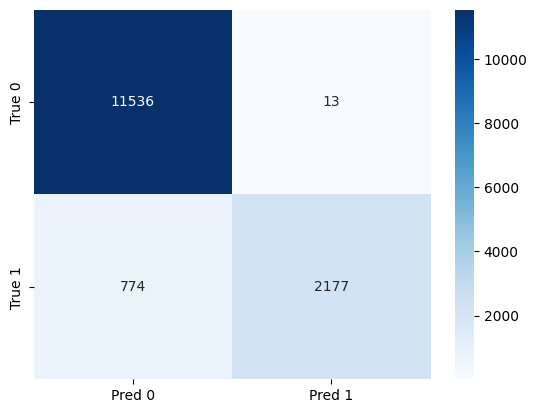

In [27]:
from sklearn.metrics import (
    classification_report, accuracy_score, f1_score,
    precision_score, recall_score, balanced_accuracy_score,
    confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = pipe.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall_1 = recall_score(y_test, y_pred, pos_label=1)  # sensitivity
recall_0 = recall_score(y_test, y_pred, pos_label=0)  # specificity
balanced_acc = balanced_accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Classification report:\n", classification_report(y_test, y_pred))
print(f"Accuracy:           {accuracy:.3f}")
print(f"F1 Score:           {f1:.3f}")
print(f"Precision:          {precision:.3f}")
print(f"Sensitivity (1):    {recall_1:.3f}")
print(f"Specificity (0):    {recall_0:.3f}")
print(f"Balanced Accuracy:  {balanced_acc:.3f}")
print("\nConfusion Matrix:")

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['True 0', 'True 1'])
plt.show()



In [28]:
from sklearn.inspection import permutation_importance
import pandas as pd

# Step 1: Fit your pipeline first
pipe.fit(X_train, y_train)

# Step 2: Compute permutation importance on test set
perm = permutation_importance(pipe, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)

# Step 3: Match feature names with importances
features = X_train.columns  # Already preprocessed column names
importances = perm.importances_mean

# Step 4: Build DataFrame and sort
importance_event_visitor = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})
importance_event_visitor = importance_event_visitor.sort_values(by='Importance', ascending=True)

# Step 5: Output top 10
print("\nFeature Importance Ranking:")
print(importance_event_visitor.head(10))


: 

In [ ]:

import pandas as pd
import plotly.express as px

# Step 1: Create state abbreviation mapping
us_state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY', 'District of Columbia': 'DC'
}

# Step 2: Map state names to abbreviations
df['STATE_ABBR'] = df['STATE_NAME'].map(us_state_abbrev)

# Step 3: Group by state and compute metrics
choropleth_data = df.groupby('STATE_ABBR').agg(
    remote_ratio=('REMOTE_BINARY', 'mean'),
    avg_salary=('AVERAGE_SALARY_STATE_REMOTE_AVG', 'mean'),
    avg_experience=('AVG_YEARS_EXPERIENCE', 'mean'),
    job_count=('STATE_NAME', 'count')
).reset_index()

# Step 4: Create the choropleth with green color scale
fig = px.choropleth(
    data_frame=choropleth_data,
    locations='STATE_ABBR',
    locationmode="USA-states",
    color='remote_ratio',
    color_continuous_scale="Greens",  
    scope="usa",
    labels={'remote_ratio': 'Remote Job Ratio'},
    hover_data={
        'remote_ratio': ':.2f',
        'avg_salary': ':.0f',
        'avg_experience': ':.1f',
        'job_count': True
    },
    title='Remote Job Ratio by State (Green), Avg Salary & Experience in Hover'
)

fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig.show()



In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Ensure 'POSTED' is in datetime format and create Year-Month
df['POSTED'] = pd.to_datetime(df['POSTED'])
df['POSTED_YM'] = df['POSTED'].dt.to_period('M').astype(str)

In [54]:
industry_trends = (
    df.groupby(['NAICS_2022_2_NAME', 'POSTED_YM'])['REMOTE_BINARY']
    .mean()
    .reset_index(name='REMOTE_RATIO')
)


In [68]:
# Step 3: Select top 5 industries with highest overall average remote ratio
top_industries = (
    industry_trends.groupby('NAICS_2022_2_NAME')['REMOTE_RATIO']
    .mean()
    .sort_values(ascending=False)
    .head(5)
    .index.tolist()
)
filtered_trends = industry_trends[industry_trends['NAICS_2022_2_NAME'].isin(top_industries)]

In [110]:
import plotly.express as px

fig = px.line(
    filtered_trends,
    x='POSTED_YM',
    y='REMOTE_RATIO',
    color='NAICS_2022_2_NAME',
    markers=True,
    title="Top Industries: Remote Job Trends Over Time"
)

fig.update_layout(
    xaxis_title="Posted Month",
    yaxis_title="Remote Job Ratio",
    legend_title="Industry",
    legend=dict(x=1.02, y=1, bordercolor="Black"),
    margin=dict(l=40, r=40, t=60, b=40),
    width=1000,
    height=500
)

fig.update_xaxes(tickangle=45)
fig.show()


In [75]:
#Groupby industry + month and calculate both:
industry_month_stats = df.groupby(['NAICS_2022_2_NAME', 'POSTED_YM']).agg(
    TOTAL_JOBS=('REMOTE_BINARY', 'count'),
    REMOTE_RATIO=('REMOTE_BINARY', 'mean')
).reset_index()

In [79]:
job_count = df.groupby(['NAICS_2022_2_NAME', 'POSTED_YM']).size().reset_index(name='JOB_COUNT')

In [81]:
remote_ratio = df.groupby(['NAICS_2022_2_NAME', 'POSTED_YM'])['REMOTE_BINARY'].mean().reset_index(name='REMOTE_RATIO')


In [82]:
industry_month_stats = pd.merge(remote_ratio, job_count, on=['NAICS_2022_2_NAME', 'POSTED_YM'])


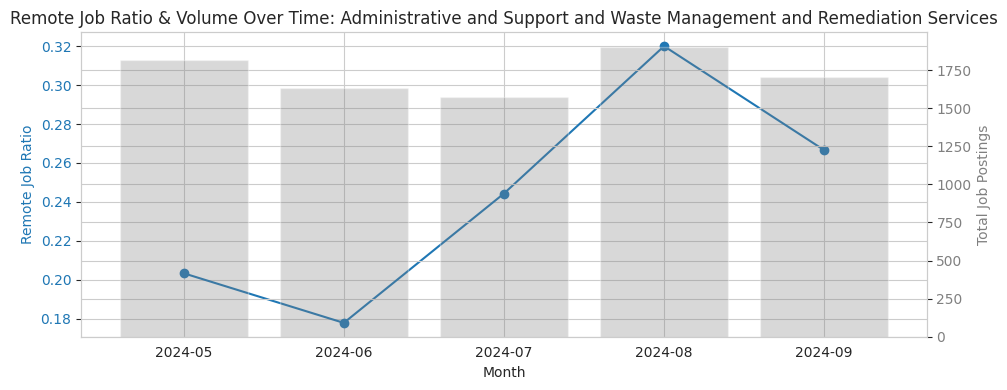

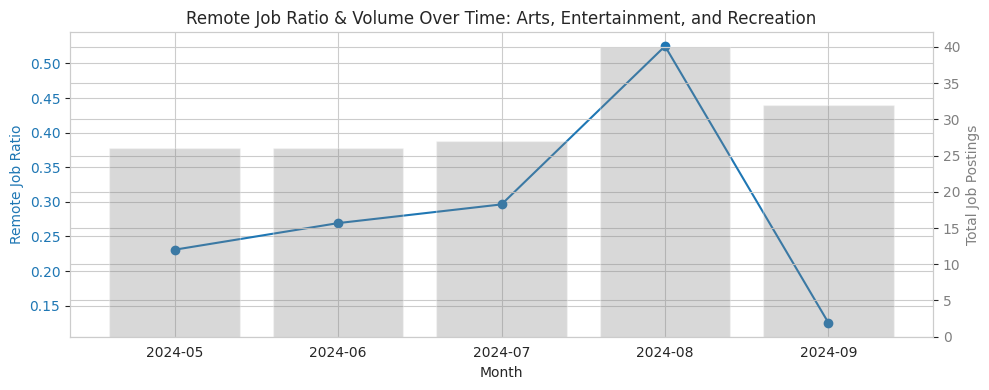

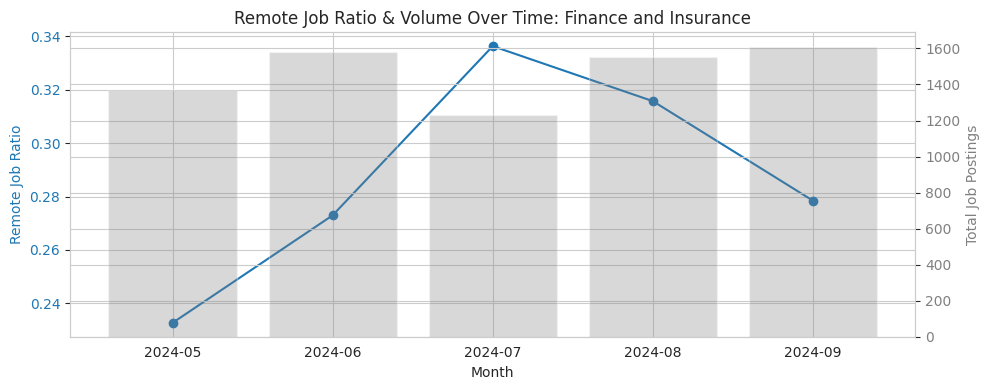

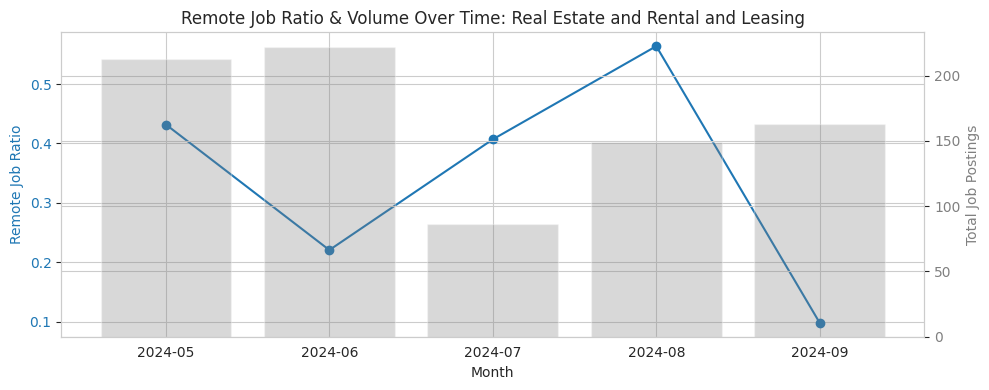

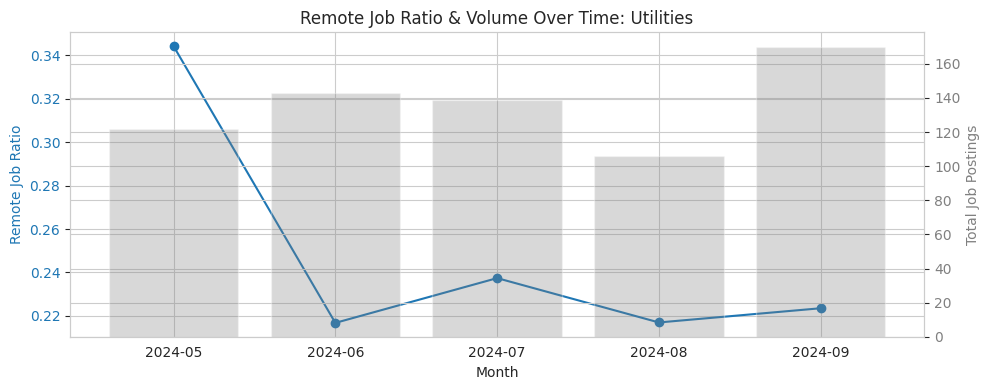

In [113]:


import matplotlib.pyplot as plt

# Choose 2–3 industries to plot (or loop one at a time)
selected_industries = [
    'Administrative and Support and Waste Management and Remediation Services',
    'Arts, Entertainment, and Recreation',
    'Finance and Insurance',
    'Real Estate and Rental and Leasing',
    'Utilities'
]



for industry in selected_industries:
    data = industry_month_stats[industry_month_stats['NAICS_2022_2_NAME'] == industry]  

    fig, ax1 = plt.subplots(figsize=(10, 4))

    # Plot remote ratio
    ax1.plot(data['POSTED_YM'], data['REMOTE_RATIO'], color='tab:blue', marker='o')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Remote Job Ratio', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_title(f"Remote Job Ratio & Volume Over Time: {industry}")

    # Plot job count on secondary y-axis
    ax2 = ax1.twinx()
    ax2.bar(data['POSTED_YM'], data['JOB_COUNT'], color='tab:gray', alpha=0.3)
    ax2.set_ylabel('Total Job Postings', color='gray')
    ax2.tick_params(axis='y', labelcolor='gray')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



